In [1]:
import os
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

os.chdir('../..')
from utils.load_data import *
train, test = load_regression()

/Users/zhangqi977/miniconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [4]:
train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [5]:
test.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year
count,4705.000000,5681.000000,5681.000000,5681.000000
mean,12.695633,0.065684,141.023273,1997.828903
std,4.664849,0.051252,61.809091,8.372256
min,4.555000,0.000000,31.990000,1985.000000
25%,8.645000,0.027047,94.412000,1987.000000
50%,12.500000,0.054154,141.415400,1999.000000
75%,16.700000,0.093463,186.026600,2004.000000
max,21.350000,0.323637,266.588400,2009.000000


In [2]:
train = train.fillna(-999)
test = test.fillna(-999)

# category features should be transformed to 'category' type if you want lgbm to directly deal with categorical features, 
# or you should do label encoding or onehot encoding yourself.
cat_features = list(train.select_dtypes('object').columns)
train[cat_features] = train[cat_features].astype('category')
test[cat_features] = test[cat_features].astype('category')

In [3]:
X = train.drop(['Item_Outlet_Sales'], axis=1)
y = train.Item_Outlet_Sales
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=666)

In [4]:
X_train.dtypes

Item_Identifier              category
Item_Weight                   float64
Item_Fat_Content             category
Item_Visibility               float64
Item_Type                    category
Item_MRP                      float64
Outlet_Identifier            category
Outlet_Establishment_Year       int64
Outlet_Size                  category
Outlet_Location_Type         category
Outlet_Type                  category
dtype: object

In [20]:
import json
import os
import logging

def mkdirs(dir2make):
    if isinstance(dir2make,list):
        for i_dir in dir2make:
            if not os.path.exists(i_dir):
                os.makedirs(i_dir)
    elif isinstance(dir2make,str):
        if not os.path.exists(dir2make):
            os.makedirs(dir2make)
    else:
        raise ValueError("dir2make should be string or list type.")
        
def func_label_encoding(df,col,to_save=True,save_dir='./model_meta_data',file_marker=None,transform=True,overwrite=False):
    mkdirs(save_dir)
    encoding_dict = {} 
    df[col] = df[col].fillna('-999')
    df[col] = df[col].apply(lambda x: '-999' if x == -999 else x)
    df[col] = df[col].astype('str')
    all_lst = list(df[col].unique())
    all_lst = list(map(str,all_lst))
    for i,iu in enumerate(all_lst):
        encoding_dict[iu] = i
    if to_save:
        if file_marker is None:
            file_marker = col
        file_nm = f'encoding_{file_marker}.json'
        abs_file_path = os.path.join(save_dir, file_nm)
        if not os.path.exists(abs_file_path):
            with open(abs_file_path, 'w') as f:
                json.dump(encoding_dict, f)
        else:
            if overwrite:
                logging.warning(f"\nFile '{abs_file_path}' already exists and will be overwrited!")
                os.remove(abs_file_path)
                with open(abs_file_path, 'w') as f:
                    json.dump(encoding_dict, f)
            else:
                logging.warning(f"\nFile '{abs_file_path}' already exists and did not be overwrited!\
                \nIf you want to overwrite it, set argument overwrite as True")
    if '-999' in encoding_dict:
        encoding_dict['-999'] = -999
    if transform:
        df[col] = df[col].apply(lambda x: encoding_dict[x] if x in encoding_dict else -888)
    return encoding_dict


In [19]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_validation, y_validation, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 10,
#     'learning_rate': 0.0799,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=30,
                categorical_feature=cat_features,
                learning_rates=lambda iter: 0.0799 * (0.99 ** iter),
                verbose_eval=30)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_validation, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_validation, y_pred) ** 0.5)

Starting training...
Training until validation scores don't improve for 30 rounds.
[30]	valid_0's l2: 1.20002e+06	valid_0's l1: 789.852
[60]	valid_0's l2: 1.14436e+06	valid_0's l1: 753.569
[90]	valid_0's l2: 1.13979e+06	valid_0's l1: 747.956
[120]	valid_0's l2: 1.14044e+06	valid_0's l1: 746.575
Early stopping, best iteration is:
[91]	valid_0's l2: 1.13896e+06	valid_0's l1: 747.532
Saving model...
Starting predicting...
The rmse of prediction is: 1067.220778490978


/Users/zhangqi977/miniconda3/lib/python3.7/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Item_Fat_Content', 'Item_Identifier', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Size', 'Outlet_Type']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/zhangqi977/miniconda3/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


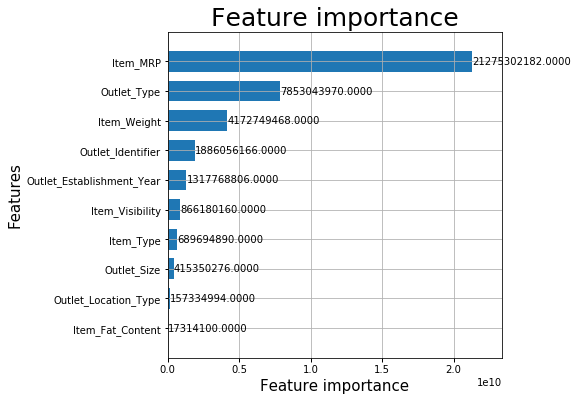

In [62]:
import matplotlib.pyplot as plt

def get_sorted_importance_kv(gbm, importance_type='gain'):
    """
    get feature importance of the booster and sort by the importance value
    """
    importance = gbm.feature_importance(importance_type=importance_type)
    feature_name = gbm.feature_name()
    tuples = sorted(zip(feature_name, importance), key=lambda x: x[1], reverse=True)
    labels, values = zip(*tuples)
    return labels, values

def plot_importance(gbm,importance_type='split',figsize=(6,6)):
    ax = lgb.plot_importance(gbm, height=0.7,importance_type=importance_type,figsize=figsize, precision=4)
    ax.set_ylabel('Features', fontsize=15)
    ax.set_xlabel('Feature importance', fontsize=15)
    ax.set_title('Feature importance', fontsize=25)
    plt.tick_params(labelsize='10', width=1)
    plt.show()
    
labels_1, values_1 = get_sorted_importance_kv(gbm, importance_type='gain')
labels_2, values_2 = get_sorted_importance_kv(gbm, importance_type='split')
plot_importance(gbm,importance_type='gain',figsize=(6,6))

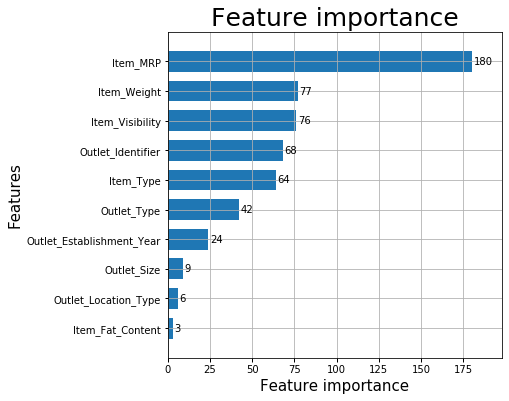

In [63]:
plot_importance(gbm,importance_type='split',figsize=(6,6))

# feature selection

In [73]:
import numpy as np

X_train_fe_sele = X_train.copy()
y_train_fe_sele = y_train.copy()

# final train
lgb_fe_select_param = {'seed': 2019, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'metric': 'l2_root', 'n_jobs': -1}
bad_features=[]
LENGTH = len(labels_1)
for i in range(0,-(LENGTH+1),-1):
    print("====================================================")
    print(f"{-i} Iteration...")
    print("====================================================")
    
    if i == 0 :
        lgb_train_new = lgb.Dataset(X_train_fe_sele, y_train_fe_sele)
        cv_dict = lgb.cv(lgb_fe_select_param, lgb_train_new, num_boost_round=1000, folds=None, nfold=5, 
                         stratified=False, shuffle=False, metrics=None, fobj=None, feval=None, 
                         init_model=None, feature_name='auto', categorical_feature='auto', 
                         early_stopping_rounds=50, fpreproc=None, verbose_eval=10, 
                         show_stdv=True, seed=0, callbacks=None)

        # Extract the min rmse, Loss must be minimized
        bst_loss = np.min(cv_dict['rmse-mean'])
        # Boosting rounds that returned the lowest cv rmse
        bst_trees = int(np.argmin(cv_dict['rmse-mean']) + 1)
        print(f"bst_loss:{bst_loss}, bst_trees:{bst_trees}")
    else:
        labels_i = labels_1[i]
        X_train_new = X_train_fe_sele.drop(labels_i, axis=1)
        lgb_train_new = lgb.Dataset(X_train_new, y_train_fe_sele)
        cv_dict = lgb.cv(lgb_fe_select_param, lgb_train_new, num_boost_round=1000, folds=None, nfold=5, 
                         stratified=False, shuffle=False, metrics=None, fobj=None, feval=None, 
                         init_model=None, feature_name='auto', categorical_feature='auto', 
                         early_stopping_rounds=50, fpreproc=None, verbose_eval=10, 
                         show_stdv=True, seed=0, callbacks=None)
        # Extract the min rmse, Loss must be minimized
        loss = np.min(cv_dict['rmse-mean'])
        # Boosting rounds that returned the lowest cv rmse
        n_estimators = int(np.argmin(cv_dict['rmse-mean']) + 1)
        if loss <= bst_loss:
            print(f"Successfully remove <{labels_i}>")
            bst_loss = loss
            bst_trees = n_estimators
            X_train_fe_sele = X_train_new
            bad_features.append(labels_i) 
        else:
            print("No bad feature found...")
        print(f"bst_loss:{bst_loss}, bst_trees:{bst_trees}")

0 Iteration...
[10]	cv_agg's rmse: 1180.14 + 42.3847
[20]	cv_agg's rmse: 1102.44 + 51.7541
[30]	cv_agg's rmse: 1098.91 + 55.0894
[40]	cv_agg's rmse: 1102.4 + 55.4107
[50]	cv_agg's rmse: 1106.16 + 55.7967
[60]	cv_agg's rmse: 1111.31 + 54.7372
[70]	cv_agg's rmse: 1115.46 + 54.5881
bst_loss:1098.181297935164, bst_trees:27
1 Iteration...
[10]	cv_agg's rmse: 1180.14 + 42.3847
[20]	cv_agg's rmse: 1102.44 + 51.7541
[30]	cv_agg's rmse: 1098.91 + 55.0894
[40]	cv_agg's rmse: 1102.4 + 55.4107
[50]	cv_agg's rmse: 1106.16 + 55.7967
[60]	cv_agg's rmse: 1111.31 + 54.7372
[70]	cv_agg's rmse: 1115.46 + 54.5881
Successfully remove <Item_Identifier>
bst_loss:1098.181297935164, bst_trees:27
2 Iteration...
[10]	cv_agg's rmse: 1180.54 + 42.1716
[20]	cv_agg's rmse: 1103.25 + 51.2294
[30]	cv_agg's rmse: 1099.1 + 56.0716
[40]	cv_agg's rmse: 1104.09 + 57.7416
[50]	cv_agg's rmse: 1109.45 + 55.9474
[60]	cv_agg's rmse: 1113.16 + 54.6698
[70]	cv_agg's rmse: 1116.8 + 56.0229
No bad feature found...
bst_loss:1098.181

Training until validation scores don't improve for 50 rounds.
[10]	training's rmse: 1148.63	valid_1's rmse: 1138.83
[20]	training's rmse: 1025.05	valid_1's rmse: 1072.06
[30]	training's rmse: 977.924	valid_1's rmse: 1075.56
[40]	training's rmse: 944.963	valid_1's rmse: 1084.26
[50]	training's rmse: 919.064	valid_1's rmse: 1091.47
[60]	training's rmse: 894.585	valid_1's rmse: 1097.8
[70]	training's rmse: 875.626	valid_1's rmse: 1104.31
Early stopping, best iteration is:
[23]	training's rmse: 1006.47	valid_1's rmse: 1071.94
Training until validation scores don't improve for 50 rounds.
[10]	training's rmse: 1117.84	valid_1's rmse: 1252.64
[20]	training's rmse: 993.112	valid_1's rmse: 1201.69
[30]	training's rmse: 945.384	valid_1's rmse: 1203.6
[40]	training's rmse: 913.906	valid_1's rmse: 1212.31
[50]	training's rmse: 888.103	valid_1's rmse: 1218.9
[60]	training's rmse: 869.266	valid_1's rmse: 1223.4
[70]	training's rmse: 852.149	valid_1's rmse: 1226.96
Early stopping, best iteration is:


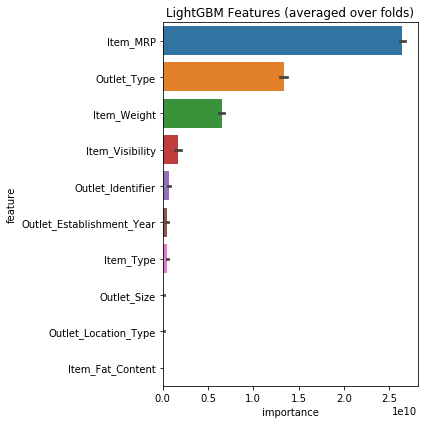

Training until validation scores don't improve for 50 rounds.
[10]	training's rmse: 1148.63	valid_1's rmse: 1138.83
[20]	training's rmse: 1025.05	valid_1's rmse: 1072.06
[30]	training's rmse: 977.924	valid_1's rmse: 1075.56
[40]	training's rmse: 944.963	valid_1's rmse: 1084.26
[50]	training's rmse: 919.064	valid_1's rmse: 1091.47
[60]	training's rmse: 894.585	valid_1's rmse: 1097.8
[70]	training's rmse: 875.626	valid_1's rmse: 1104.31
Early stopping, best iteration is:
[23]	training's rmse: 1006.47	valid_1's rmse: 1071.94
Training until validation scores don't improve for 50 rounds.
[10]	training's rmse: 1117.84	valid_1's rmse: 1252.64
[20]	training's rmse: 993.112	valid_1's rmse: 1201.69
[30]	training's rmse: 945.384	valid_1's rmse: 1203.6
[40]	training's rmse: 913.906	valid_1's rmse: 1212.31
[50]	training's rmse: 888.103	valid_1's rmse: 1218.9
[60]	training's rmse: 869.266	valid_1's rmse: 1223.4
[70]	training's rmse: 852.149	valid_1's rmse: 1226.96
Early stopping, best iteration is:


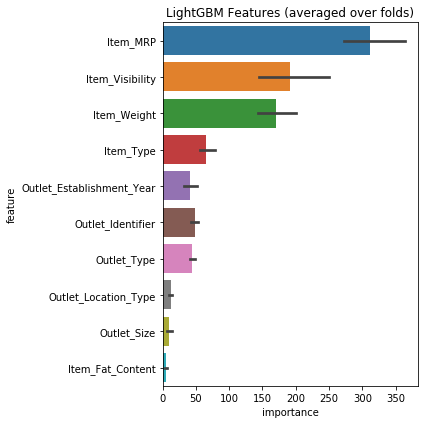

In [80]:
# feature selection by feature importance:
from sklearn.model_selection import KFold, check_cv
import seaborn as sns
def feature_selector_by_importance(X_raw, y_raw, cv, importance_type='gain',select_size=0.7,to_savefig=False):
    
    """
    Args:
        X_raw: pd.DataFrame, feature df, irrelevant cols should be removed before inputting.
        y_raw: target pd.Series.
        cv: cv methods
    Return:
        feature_importance_df: pd.DataFrame of feature importance
    """
    if (select_size>1) or (select_size<=0):
        raise ValueError(f"select_size should be in the range of (0,1], got {select_size} instead.")
    features = list(X_raw.columns)
    N_select_features = round(len(features)*select_size)
    cv = check_cv(cv)
    feature_importance_df = pd.DataFrame()
    
    lgb_params = {'seed': 2019, 
                  'boosting_type':'gbdt',
                  'learning_rate': 0.1, 
                  'metric': 'l2_root', 
                  'n_jobs': -1}
    
    for fold, (trn_idx, val_idx) in enumerate(cv.split(X_raw)):
        
        trn_data = lgb.Dataset(X_raw.iloc[trn_idx], label=y_raw.iloc[trn_idx])
        val_data = lgb.Dataset(X_raw.iloc[val_idx], label=y_raw.iloc[val_idx])
        evals_result = {}
        lgb_reg = lgb.train(lgb_params, trn_data, 1000,
                            valid_sets = [trn_data, val_data],
                            early_stopping_rounds=50,
                            verbose_eval = 10,
                            evals_result=evals_result)
        # warnings.warn('categorical_feature in param dict is overridden.')
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = lgb_reg.feature_importance(importance_type=importance_type)
        fold_importance_df["fold"] = fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
    feature_importance_df_final = feature_importance_df[["feature", "importance"]].groupby(
        "feature").mean().sort_values(by="importance", ascending=False)
    
    feature_to_select = list(feature_importance_df_final[:N_select_features+1].index)
    feature_to_remove = list(feature_importance_df_final[N_select_features+1:].index)
    print(f"feature_to_remove: {feature_to_remove}")
    best_features_all_folds = feature_importance_df.loc[feature_importance_df.feature.isin(feature_to_select)]
    plt.figure(figsize=(6, 6))
    sns.barplot(x="importance", y="feature", data=best_features_all_folds.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (averaged over folds)')
    plt.tight_layout()
    plt.show()
    if to_savefig:
        plt.savefig('lgbm_importances.png')
    return feature_importance_df_final,feature_to_select

feature_importance_df_final_1,feature_to_select_1 = feature_selector_by_importance(X_train, y_train, cv=5, importance_type='gain',select_size=0.8,to_savefig=False)
feature_importance_df_final_2,feature_to_select_2 = feature_selector_by_importance(X_train, y_train, cv=5, importance_type='split',select_size=0.8,to_savefig=False)